<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/%E6%8B%A1%E6%95%A3%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92%E7%94%A8%E3%81%84%E3%81%9F%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================
# Diffusion-based Anomaly Detection (DDPM, reconstruction error)
# Google Colab ready / 日本語コメント, 英語キャプション
# ============================================================

# 依存関係（軽量のみ）。torchmetrics を使って SSIM を計算します。
!pip -q install einops torchmetrics

# ---- Imports ----
import math, random, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Subset
from einops import rearrange
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure


In [ ]:
# ---- Device ----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# -----------------------------
# 1) データ用ユーティリティ
# -----------------------------
# 画像を [-1,1] のレンジに正規化
transform = transforms.Compose([
    transforms.ToTensor(),                 # [0,1]
    transforms.Normalize((0.5,), (0.5,))   # [-1,1]
])

In [ ]:
# MNIST を読み込み
root = "./data"
train_ds = datasets.MNIST(root, train=True,  download=True, transform=transform)
test_ds  = datasets.MNIST(root, train=False, download=True, transform=transform)

digit_normal = 0  # 正常クラス（0の数字）だけで学習

# 学習データ: 正常のみにフィルタ
train_idx = [i for i, (x, y) in enumerate(train_ds) if y == digit_normal]
# 時間短縮のためサブセット（必要に応じて増減）
train_idx = train_idx[:10000]
train_ds_norm = Subset(train_ds, train_idx)

# テストデータ: 正常(0) + 異常(0以外) を混在
test_x, test_y = [], []
for i, (x, y) in enumerate(test_ds):
    test_x.append(x)
    test_y.append(0 if y == digit_normal else 1)  # 0: normal, 1: anomaly
test_x = torch.stack(test_x)  # (N,1,28,28)
test_y = torch.tensor(test_y)

In [ ]:
# 異常をより分かりやすくするため、異常クラスに局所ノイズパッチを注入
def add_local_noise(x, labels, p=0.7):
    """
    x: (N,1,28,28) [-1,1]
    labels: (N,) 0=normal,1=anomaly
    p: 異常ラベルに対してノイズを入れる確率
    """
    x = x.clone()
    N = x.size(0)
    for i in range(N):
        if labels[i] == 1 and random.random() < p:
            h, w = 28, 28
            rh, rw = random.randint(6, 12), random.randint(6, 12)
            r0, c0 = random.randint(0, h-rh), random.randint(0, w-rw)
            noise_patch = torch.clamp(torch.randn(1, rh, rw) * 1.5, -2.0, 2.0)
            x[i, :, r0:r0+rh, c0:c0+rw] = torch.tanh(noise_patch)
    return x

test_x_noisy = add_local_noise(test_x, test_y, p=0.7)

# DataLoader
batch_size = 128
train_loader = DataLoader(train_ds_norm, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
# -----------------------------
# 2) 拡散過程（DDPM）パラメータ
# -----------------------------
T = 300  # 拡散時間ステップ（小さめでOK）
beta_start, beta_end = 1e-4, 0.02
betas = torch.linspace(beta_start, beta_end, T, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

def extract(a, t, x_shape):
    # ベクトル a から時刻 t の係数を取り出し、x の形にブロードキャスト
    out = a.gather(-1, t).float()
    return out.reshape(-1, 1, 1, 1).expand(x_shape)

def q_sample(x0, t, noise=None):
    # 正規分布ノイズを加えて x0 -> x_t を生成
    if noise is None:
        noise = torch.randn_like(x0)
    return (extract(sqrt_alphas_cumprod, t, x0.shape) * x0 +
            extract(sqrt_one_minus_alphas_cumprod, t, x0.shape) * noise)


In [ ]:
# -----------------------------
# 3) 小型 U-Net 本体
# -----------------------------
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, out_ch))
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act = nn.SiLU()
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.conv1(x)
        h = self.norm1(h)
        h = h + self.time_mlp(t_emb)[:, :, None, None]
        h = self.act(h)
        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act(h)
        return h + self.skip(x)

def sinusoidal_time_embedding(t, dim=128):
    # 正弦時間埋め込み
    half = dim // 2
    freqs = torch.exp(torch.linspace(math.log(1.0), math.log(10000.0), half, device=t.device))
    args = t[:, None] * freqs[None, :]
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    return emb

class SimpleUNet(nn.Module):
    def __init__(self, time_dim=128, ch=32):
        super().__init__()
        self.time_dim = time_dim
        self.time_mlp = nn.Sequential(nn.Linear(time_dim, time_dim), nn.SiLU(), nn.Linear(time_dim, time_dim))

        self.down1 = Block(1, ch, time_dim)
        self.down2 = Block(ch, ch*2, time_dim)
        self.down3 = Block(ch*2, ch*2, time_dim)

        self.pool = nn.AvgPool2d(2)

        self.mid = Block(ch*2, ch*2, time_dim)

        self.up1 = Block(ch*2, ch*2, time_dim)
        self.up2 = Block(ch*2, ch, time_dim)
        self.up3 = Block(ch, ch, time_dim)

        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.out = nn.Conv2d(ch, 1, 1)

    def forward(self, x, t):
        t = sinusoidal_time_embedding(t, self.time_dim)
        t = self.time_mlp(t)

        d1 = self.down1(x, t)          # (B,ch,28,28)
        d2 = self.down2(self.pool(d1), t)  # (B,2ch,14,14)
        d3 = self.down3(self.pool(d2), t)  # (B,2ch,7,7)

        mid = self.mid(d3, t)

        u1 = self.up1(mid, t)
        u1 = self.upsample(u1) + d2
        u2 = self.up2(u1, t)
        u2 = self.upsample(u2) + d1
        u3 = self.up3(u2, t)

        out = self.out(u3)
        return out

model = SimpleUNet().to(device)

In [ ]:
# -----------------------------
# 4) 学習ループ（ε予測のMSE）
# -----------------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
epochs = 2  # 時間に応じて調整（2〜3で十分動作確認可能）
print_interval = 200

def train():
    model.train()
    global_step = 0
    start = time.time()
    for ep in range(1, epochs+1):
        for i, (x, _) in enumerate(train_loader):
            x = x.to(device)  # [-1,1]
            b = x.size(0)
            t = torch.randint(0, T, (b,), device=device).long()
            noise = torch.randn_like(x)
            xt = q_sample(x, t, noise)
            # 目標は注入した ε
            eps_pred = model(xt, t)
            loss = F.mse_loss(eps_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            global_step += 1
            if global_step % print_interval == 0:
                print(f"epoch {ep} step {global_step} loss {loss.item():.4f}")
        print(f"Epoch {ep} done. elapsed {time.time()-start:.1f}s")

train()

In [ ]:
# -----------------------------
# 5) 逆拡散（少数ステップで再生成）
# -----------------------------
@torch.no_grad()
def denoise_from_t(x0, t_start=60, steps=60):
    """
    x0: 入力画像（[-1,1]）
    t_start: ここから逆拡散を開始（= 軽くノイズを被せた状態から戻す）
    steps: 逆拡散ステップ数（DDIM風の平均更新で短縮）
    """
    model.eval()
    b = x0.size(0)
    # まず x0 にノイズを付与して x_t を作る
    t0 = torch.full((b,), t_start-1, device=device, dtype=torch.long)
    xt = q_sample(x0, t0)

    # 均等サンプリングの時刻列（DDIM風、η=0 相当）
    ts = torch.linspace(t_start-1, 0, steps, device=device).long()
    for ti in ts:
        t = torch.full((b,), int(ti.item()), device=device, dtype=torch.long)
        eps = model(xt, t)
        # 予測 x0
        x0_pred = (xt - extract(sqrt_one_minus_alphas_cumprod, t, xt.shape)*eps) / extract(sqrt_alphas_cumprod, t, xt.shape)
        x0_pred = torch.clamp(x0_pred, -1, 1)
        # 次の x_t（平均遷移のみ）
        if t.min() > 0:
            ac_prev = extract(alphas_cumprod[:-1], t-1, xt.shape)  # ᾱ_{t-1}
            xt = torch.sqrt(ac_prev)*x0_pred + torch.sqrt(1-ac_prev)*eps
        else:
            xt = x0_pred
    return xt.clamp(-1, 1)

In [ ]:
# -----------------------------
# 6) 推論：異常スコアの計算（L2 + 1-SSIM）
# -----------------------------
# SSIM メトリクス（学習レンジ [-1,1] なので data_range=2.0）
ssim_metric = StructuralSimilarityIndexMeasure(data_range=2.0, reduction='none').to(device)

@torch.no_grad()
def anomaly_scores(x, use_ssim=True):
    """
    x: (N,1,28,28), [-1,1]
    1) 入力を軽くノイズ化して逆拡散で再生成
    2) L2 と (1-SSIM) を合成して異常スコアを作成
    """
    x = x.to(device)
    x_hat = denoise_from_t(x, t_start=60, steps=60)

    # L2（画素平均）
    l2 = ((x - x_hat) ** 2).flatten(1).mean(dim=1).detach().cpu().numpy()

    if use_ssim:
        # SSIM（大きいほど類似 → 異常度は 1-SSIM）
        ssim_vals = ssim_metric(x, x_hat).detach().cpu().numpy()
        score = 0.5 * l2 + 0.5 * (1.0 - ssim_vals)  # 重みは簡易に 0.5/0.5
        return score, l2, 1.0 - ssim_vals, x_hat
    else:
        return l2, l2, None, x_hat

In [ ]:
# -----------------------------
# 7) テスト評価（スコア, AUC/AUPR）
# -----------------------------
test_loader = DataLoader(list(zip(test_x_noisy, test_y)), batch_size=256, shuffle=False)

scores, labels = [], []
recons = []
for xb, yb in test_loader:
    sc, _, _, xhat = anomaly_scores(xb, use_ssim=True)
    scores.append(sc)
    labels.append(yb.numpy())
    recons.append(xhat.cpu())
scores = np.concatenate(scores)
labels = np.concatenate(labels)
recons = torch.cat(recons, dim=0)  # (N,1,28,28)

auc  = roc_auc_score(labels, scores)
aupr = average_precision_score(labels, scores)
print(f"AUC: {auc:.3f}  AUPR: {aupr:.3f}")


In [ ]:

# -----------------------------
# 8) 可視化：元/再生成/差分ヒートマップ
# -----------------------------
def to_numpy_img(x):
    # [-1,1] -> [0,1] に戻して numpy 化
    x = (x.clamp(-1,1) + 1) * 0.5
    return x.detach().cpu().numpy()

@torch.no_grad()
def show_examples(indices=None, n=8):
    """
    ランダムに正常・異常を混ぜて n 枚を表示。
    上段：Input（label 表示）
    中段：Reconstruction
    下段：Difference heatmap（score 表示）
    """
    if indices is None:
        pos = np.where(labels == 1)[0]
        neg = np.where(labels == 0)[0]
        n_pos = max(1, n // 2)
        n_neg = n - n_pos
        pick = np.concatenate([np.random.choice(pos, n_pos, replace=False),
                               np.random.choice(neg, n_neg, replace=False)])
        np.random.shuffle(pick)
    else:
        pick = np.array(indices)

    x0 = test_x_noisy[pick]
    y0 = labels[pick]
    sc, l2_only, ssim_only, xhat = anomaly_scores(x0, use_ssim=True)
    diff = (x0 - xhat.cpu()).pow(2)

    fig, axes = plt.subplots(3, len(pick), figsize=(1.8*len(pick), 4.8))
    for i, idx in enumerate(pick):
        axes[0,i].imshow(to_numpy_img(x0[i])[0], cmap='gray', vmin=0, vmax=1)
        axes[0,i].set_title(f"Input (label={y0[i]})")
        axes[1,i].imshow(to_numpy_img(xhat[i])[0], cmap='gray', vmin=0, vmax=1)
        axes[1,i].set_title("Reconstruction")
        heat = to_numpy_img(diff[i] / max(diff[i].max().item(), 1e-6))[0]
        axes[2,i].imshow(heat, cmap='inferno')
        axes[2,i].set_title(f"Diff map\nscore={sc[i]:.3f}")
        for r in range(3):
            axes[r,i].axis('off')
    plt.suptitle("Diffusion-based Anomaly Detection: Input / Reconstruction / Difference", fontsize=16)
    plt.tight_layout()
    plt.show()

show_examples()


Device: cuda
Epoch 1 done. elapsed 1.9s
Epoch 2 done. elapsed 4.1s
AUC: 0.926  AUPR: 0.991


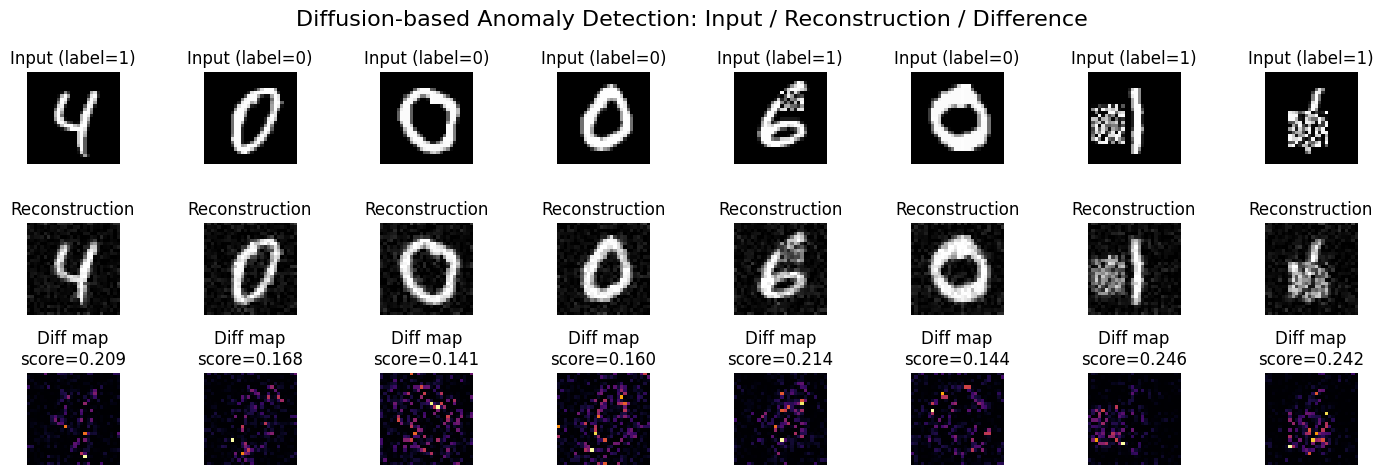

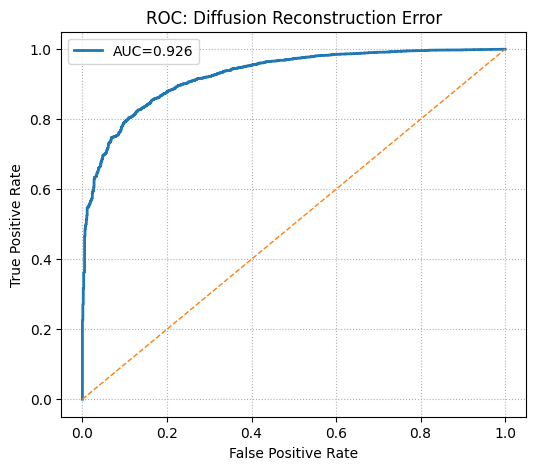

In [11]:
# -----------------------------
# 9) ROC 曲線
# -----------------------------
fpr, tpr, th = roc_curve(labels, scores)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC: Diffusion Reconstruction Error")
plt.legend()
plt.grid(True, ls=':')
plt.show()
